In [ ]:
pip install transformers

In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from transformers import BertModel, BertConfig
from transformers import BertTokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

# parameters
BATCH_SIZE = 32
NUM_EPOCHS = 3 #10
VALID_SPLIT = 0.1
MAX_LEN = 150

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

## 토크나이저 테스트

In [ ]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 하', '# # 세', '# # 요', ',', '반', '# # 갑', '# # 습', '# # 니 다', '.', '[ S E P ]']


In [ ]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


# Korean Movie Review Classification

In [ ]:
#코랩 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 데이터 전처리 준비
data_path = "/content/gdrive/MyDrive/참빛/integrated_data.csv"
data = pd.read_csv(data_path)
data.columns=['index','comments','sentiment','tokens']
token = data.iloc[:,:3]
token

,index,comments,sentiment
0,0,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ 나도 왠지 원래 가격이 20만원이란 소리 아닌가 생각했는데 ㅋㅋㅋㅋㅋㅋ,0.0
1,1,이 분은 스트리트 푸드파이터에 나와야 했음 ㅋㅋㅋㅋㅋ,0.0
2,2,방송 편집 문제 임ㅜ,0.0
3,3,네 실제로 겪어봤는데 다르지 않습니다ㅎㅎ 착한 척은 한계가 분명 있음,0.0
4,4,그게 가식적인 이미지일지도 모름,0.0
...,...,...,...
20428,20428,피해자보다 가해자를 더 보호해주는 나라 여성의 피해에 굉장히 민감하신 우리의 ㅍㅁ나라,1.0
20429,20429,이성준 ㅋ 그럼 저 교수한테 왜 친일했냐고 물어봐 ㅂㅅ아 애초에 저 교수 과거 행적...,1.0
20430,20430,미나토 대깨문이다 ㄷㄷ,1.0
20431,20431,우파 승리 415 총선 무효 ㅋㅋㅋㅋㅋ 돈도 없고 늙기만 해서 아으 추해 늙는 것도...,1.0


In [ ]:
train_data = token.sample(frac=0.8, random_state=2021)
train_data = train_data.dropna()
temp = pd.concat([train_data, token])
test_data = temp.drop_duplicates(['index'], keep=False)
test_data = test_data.dropna()
print(len(train_data), len(test_data))

16346 4087


In [ ]:
'''
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)
'''

'\n# 스페셜 토큰\nprint(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)\n\n# 토크나이저 테스트하기\nkor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")\neng_encode = tokenizer.encode("Hello world")\n\nkor_decode = tokenizer.decode(kor_encode)\neng_decode = tokenizer.decode(eng_encode)\n\nprint(kor_encode)\nprint(eng_encode)\nprint(kor_decode)\nprint(eng_decode)\n'

In [ ]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):  
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True,   # Construct attn. masks.
        truncation = True        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [ ]:

input_ids = []
attention_masks = []
token_type_ids = []
train_data_sentis = []

for train_com, train_senti in tqdm(zip(train_data["comments"], train_data["sentiment"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_com, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_sentis.append(train_senti)

    except Exception as e:
        print(e)
        print(train_com)
        pass

train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)
train_data_sentis = np.asarray(train_data_sentis, dtype=np.int32) #레이블 토크나이징 리스트

print("# comments: {}, # sentiment: {}".format(len(train_input_ids), len(train_data_sentis)))

  0%|          | 0/16346 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 16346/16346 [00:05<00:00, 2983.28it/s]

# comments: 16346, # sentiment: 16346


In [ ]:
'''
# 최대 길이: 
input_id = train_input_ids[1]
attention_mask = train_attention_masks[1]
token_type_id = train_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))
'''

[   101    100    100   9260  41919   9303  12508   9303  12508   9420
  66540  19105  80564  11287   9748   8942  16985  12424  71568  11287
   9364  41850  19709  64002   9565 119294 101450   9949  48549  11287
   9555  12965   9710    100    102      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

In [ ]:
from transformers import BertModel, TFBertModel

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=3)

# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

model_name = "bert_new"
data_out_path = '/content/gdrive/MyDrive/참빛/'
checkpoint_path = os.path.join(data_out_path, model_name,'weights.h5')   #checkpoint_path = os.path.join(data_out_path, model_name, 'weight_32_ep3.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True)

#checkpoint 저장
#cls_model.save_weights(checkpoint_path.format(epoch=0))

# 학습과 eval 시작
history = cls_model.fit(train_inputs, train_data_sentis, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback])
#validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

Epoch 1/10
409/409 [==============================] - 421s 1s/step - loss: 0.2988 - accuracy: 0.8744 - val_loss: 0.3765 - val_accuracy: 0.8557
Epoch 2/10
409/409 [==============================] - 428s 1s/step - loss: 0.2143 - accuracy: 0.9137 - val_loss: 0.3346 - val_accuracy: 0.8654
Epoch 3/10
409/409 [==============================] - 428s 1s/step - loss: 0.1457 - accuracy: 0.9429 - val_loss: 0.3787 - val_accuracy: 0.8673
Epoch 4/10
409/409 [==============================] - 427s 1s/step - loss: 0.1077 - accuracy: 0.9589 - val_loss: 0.3696 - val_accuracy: 0.8697
Epoch 5/10
409/409 [==============================] - 428s 1s/step - loss: 0.0765 - accuracy: 0.9699 - val_loss: 0.6091 - val_accuracy: 0.8612
Epoch 6/10
409/409 [==============================] - 428s 1s/step - loss: 0.0639 - accuracy: 0.9759 - val_loss: 0.5195 - val_accuracy: 0.8664
Epoch 7/10
409/409 [==============================] - 428s 1s/step - loss: 0.0480 - accuracy: 0.9824 - val_loss: 0.5524 - val_accuracy: 0.8771

In [ ]:
#cls_model.save('bert_model',save_format='tf')

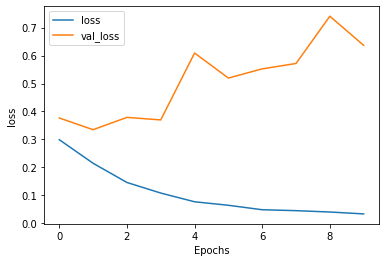

In [ ]:
plot_graphs(history, 'loss')

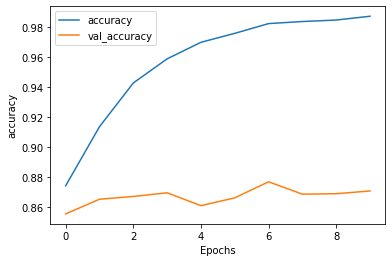

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
#pip install -q pyyaml h5py

In [ ]:
from tensorflow.keras.models import load_model
#loaded_model = load_model('/content/drive/MyDrive/참빛/bert_model_32_ep3/bert_weight.h5')

# Korean Movie Review Test 데이터

In [ ]:
test_data.head()

,index,comments,sentiment
4,4,그게 가식적인 이미지일지도 모름,0.0
14,14,송지효 상자 속 물건 맞추기 할 때 해주세요 ㅠㅠ 그거 진짜 보고 싶은데 영상도 없...,0.0
31,31,김지원 천진난만하게 웃는 거 너무 귀엽네,0.0
41,41,타팬이 봐도 이 특 너무 예쁘다,0.0
52,52,옛날이 진짜진짜 재밌었는데 ㅠㅠ 하,0.0


In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_sentis = []

#for test_com in test_data['comments']:
for test_com, test_senti in tqdm(zip(test_data["comments"], test_data["sentiment"]), total=len(test_data)):  
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_com, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_sentis.append(test_senti)

    except Exception as e:
        print(e)
        print(test_com)
        pass

test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)

test_data_sentis = np.asarray(test_data_sentis, dtype=np.int32) #레이블 토크나이징 리스트

print("# comments: {}, # sentiment: {}".format(len(test_input_ids), len(test_data_sentis)))

  0%|          | 0/4087 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 4087/4087 [00:01<00:00, 3092.16it/s]


# comments: 4087, # sentiment: 4087


In [ ]:
results = cls_model.evaluate(test_inputs, test_data_sentis)
print("test loss, test acc: ", results)

In [ ]:
#cls_model.save_weights('/content/drive/MyDrive/참빛/bert_model_32_ep3/bert_weight.h5')

#테스트

In [ ]:
#test_data['comments']만 돌려본 것 - batchsize 32 ep3
res = cls_model.predict(test_inputs)
res

array([[10.627917  ,  6.048119  , -0.7330676 , ..., -0.7059858 ,
        -1.2408012 , -1.1609138 ],
       [10.618618  ,  7.0486536 , -0.8452959 , ..., -1.0212048 ,
        -1.2504281 , -1.1802604 ],
       [10.527312  ,  7.309893  , -0.90829617, ..., -1.1257821 ,
        -1.2125818 , -1.1829885 ],
       ...,
       [ 4.566683  , 10.494642  , -1.4416629 , ..., -1.0544237 ,
        -0.6077887 , -1.0678244 ],
       [ 5.631604  , 10.7929    , -1.5139014 , ..., -1.211548  ,
        -0.72756284, -1.2359637 ],
       [ 4.293537  , 10.448087  , -1.4146842 , ..., -1.0123978 ,
        -0.5958521 , -1.0617592 ]], dtype=float32)

In [ ]:
res = tf.argmax(res,axis=1)
res

<tf.Tensor: shape=(4087,), dtype=int64, numpy=array([0, 0, 0, ..., 1, 1, 1])>

In [ ]:
comment = test_data['comments']
comment = pd.DataFrame(comment)
comment['sentiment'] = res
comment

,comments,sentiment
4,그게 가식적인 이미지일지도 모름,0
14,송지효 상자 속 물건 맞추기 할 때 해주세요 ㅠㅠ 그거 진짜 보고 싶은데 영상도 없...,0
31,김지원 천진난만하게 웃는 거 너무 귀엽네,0
41,타팬이 봐도 이 특 너무 예쁘다,0
52,옛날이 진짜진짜 재밌었는데 ㅠㅠ 하,1
...,...,...
20417,ㅋㅋㅋㅋㅋ미친 바지 교수라니,1
20420,이씨 발럼 뉸 깔 띄지 마라,1
20423,알밥 아니 ㄹㅇ 여자들은 몸캠 보낼 때 차라리 돈이라도 받앗지 쟤네는 ㅅㅂ ㅋㅋㅋㅋ...,1
20424,아니 대가리 바짝 들고 개 당당하네 진짜 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 아니 ㅋㅋㅋㅋㅋ저건 뭐...,1


In [ ]:
import numpy as np
data = np.array(['예쁜 쓰레기','당신은 정녕 미친건가요','닥쳐','너무 예뻐요','미모가 레를 넘어 미쳤어요','부모 홀수냐','어 조용히 해','이게 무슨 개소리야','아빠도 없는 게 까부네',
                 '너 몇 살이냐','ㅅㅂ개웃긴다','ㅆㄹㄱ ㅅㄲㄷㅇㅋㅋㅋㅋㅋㅋㅋㅋ','사과 좋아','밤바다'])
data = pd.DataFrame(data)
data.columns=['comments']
data

,comments
0,예쁜 쓰레기
1,당신은 정녕 미친건가요
2,닥쳐
3,너무 예뻐요
4,미모가 레를 넘어 미쳤어요
5,부모 홀수냐
6,어 조용히 해
7,이게 무슨 개소리야
8,아빠도 없는 게 까부네
9,너 몇 살이냐


In [ ]:
input_ids_res = []
attention_masks_res = []
token_type_ids_res = []
data_sentis_res = []

#for test_com, test_senti in tqdm(zip(data["comments"], data["sentiment"]), total=len(data)):
for test_com in data['comments']:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_com, MAX_LEN)
        
        input_ids_res.append(input_id)
        attention_masks_res.append(attention_mask)
        token_type_ids_res.append(token_type_id)
        #data_sentis_res.append(test_senti)

    except Exception as e:
        print(e)
        print(test_com)
        pass

input_ids_res = np.array(input_ids_res, dtype=int)
attention_masks_res = np.array(attention_masks_res, dtype=int)
type_ids_res = np.array(token_type_ids_res, dtype=int)
inputs_res = (input_ids_res, attention_masks_res, type_ids_res)

#data_sentis_res = np.asarray(data_sentis_res, dtype=np.int32) #레이블 토크나이징 리스트

#print("# comments: {}, # sentiment: {}".format(len(input_ids_res), len(data_sentis_res)))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
first_res = cls_model.predict(inputs_res)
results = tf.argmax(first_res,axis=1)
data['sentiment'] = results
data

,comments,sentiment
0,예쁜 쓰레기,1
1,당신은 정녕 미친건가요,1
2,닥쳐,1
3,너무 예뻐요,0
4,미모가 레를 넘어 미쳤어요,0
5,부모 홀수냐,0
6,어 조용히 해,0
7,이게 무슨 개소리야,1
8,아빠도 없는 게 까부네,1
9,너 몇 살이냐,0


#테스트2 - 이하 코드 무시

In [ ]:
!pip install transformers

import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from transformers import BertModel, BertConfig
from transformers import BertTokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

# parameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
MAX_LEN = 150

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

#데이터 준비
#코랩 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

data_path = "/content/gdrive/MyDrive/참빛/integrated_data.csv"
data = pd.read_csv(data_path)
data.columns=['index','comments','sentiment','tokens']
token = data.iloc[:,:3]
train_data = token.sample(frac=0.8, random_state=2021)
train_data = train_data.dropna()
temp = pd.concat([train_data, token])
test_data = temp.drop_duplicates(['index'], keep=False)
test_data = test_data.dropna()
print(len(train_data), len(test_data))

#버트 토크나이저
def bert_tokenizer(sent, MAX_LEN):  
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True,   # Construct attn. masks.
        truncation = True        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

input_ids = []
attention_masks = []
token_type_ids = []
train_data_sentis = []

for train_com, train_senti in tqdm(zip(train_data["comments"], train_data["sentiment"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_com, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_sentis.append(train_senti)

    except Exception as e:
        print(e)
        print(train_com)
        pass

train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)
train_data_sentis = np.asarray(train_data_sentis, dtype=np.int32) #레이블 토크나이징 리스트

print("# comments: {}, # sentiment: {}".format(len(train_input_ids), len(train_data_sentis)))


class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

  0%|          | 0/16346 [00:00<?, ?it/s]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
16346 4087


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 16346/16346 [00:05<00:00, 3060.55it/s]

# comments: 16346, # sentiment: 16346


In [ ]:
from transformers import BertModel, TFBertModel

test_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=46)

# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
test_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model_name = "bert_32_ep3_new"
data_out_path = '/content/gdrive/MyDrive/참빛'
checkpoint_path = os.path.join(data_out_path, model_name, 'weight_32_ep3.h5')
test_model = keras.models.load_model('/content/gdrive/MyDrive/참빛/bert_32_ep3_new')

OSError: ignored

#이하 코드는 무시

In [ ]:
'''
comment = '이제 와서 무슨 소용이겠어'
input_id, attention_mask, token_type_id = bert_tokenizer(comment, MAX_LEN)
print(input_id)

def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits
'''

[101, 9638, 17730, 9590, 12424, 9294, 50472, 9448, 96404, 118632, 12965, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'\ndef call(self, inputs, attention_mask=None, token_type_ids=None, training=False):\n        \n        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)\n        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)\n        pooled_output = outputs[1] \n        pooled_output = self.dropout(pooled_output, training=training)\n        logits = self.classifier(pooled_output)\n\n        return logits\n'

In [ ]:
#logits = cls_model.call(input_id, attention_mask, token_type_id)

In [ ]:
#tf.saved_model.save(cls_model,'/content/drive/MyDrive/참빛/bert_model_64_ep3/')

In [ ]:
#cls_model.save("bert_32ep3_model",save_format='tf')

In [ ]:
'''
# 간단한 Sequential 모델을 정의합니다
def create_model():
  model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='/content/drive/MyDrive/참빛/bert_model_64_ep3/bert_weight',
                                  num_class=2)
  optimizer = tf.keras.optimizers.Adam(3e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

  return model


model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
  ])
'''

"\nmodel = tf.keras.models.Sequential([\n    keras.layers.Dense(512, activation='relu', input_shape=(784,)),\n    keras.layers.Dropout(0.2),\n    keras.layers.Dense(10)\n  ])\n"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#reloaded_model = tf.saved_model.load('/content/drive/MyDrive/참빛/bert_model_64_ep3/bert_32ep3_model')

In [ ]:
#from tensorflow.keras.models import load_model
#loaded_model = load_model('/content/drive/MyDrive/참빛/bert_model_64_ep3/bert_model_ep3.h5')
new_model = create_model()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
cls_model.summary()

Model: "tf_bert_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_bert_model (TFBertModel)  multiple                  177853440 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 177,854,978
Trainable params: 177,854,978
Non-trainable params: 0
_________________________________________________________________


In [ ]:
new_model.summary()

ValueError: ignored

In [ ]:
new_model.evaluate(test_inputs,  test_data_sentis, verbose=2)
#print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

ValueError: ignored

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

input_ids = []
attention_masks = []
token_type_ids = []
test_data_sentis = []

input_id, attention_mask, token_type_id = bert_tokenizer(test_com, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_sentis.append(test_senti)

In [ ]:
#latest = tf.train.latest_checkpoint(checkpoint_dir)
'''
# 테스트 정확도 확인
loaded_model = load_model('weights.h5')
print('\n테스트 정확도: %4f' % (loaded_model.evaluate(test_inputs, test_data_sentis)))

new_model = create_model()
new_model.load_weights(latest)
loss, acc = new_model.evaluate(test_inputs,  test_data_sentis, verbose=2)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))
'''

#유튜브 영상 댓글 테스트셋

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/텍마팀플/채널모든댓글.csv',index_col=0)
data = data.drop(['topic'],axis=1)
data = data.drop(['token'],axis=1)
data["label"] = 1
data.head()

,comments,label
0,헐 도안 굉장히 까다로우셨을 텐데 너무 이쁘게 잘 나온 것 같아요 역시 다정님 답습니다,1
1,다정하게 단순한 도안도 색 배치가 좋다면 더할 나위 없이 간결하고 예쁜 것 같아요 ...,1
2,꽃 할 때 후회했었어요 ㅎㅎㅎ 세밀하게 하는 게 힘들더라고요 다음번에는 좀 단순한...,1
3,대박터프팅러그란 말도 첨 들어보는 것 같아요 역시 손으로 하시는 건 다 잘하시는 것...,1
4,앗 홈데렐라에서 보셨군요 아직 재방송을 하나 보네요 ㅎㅎㅎ 반가워해 주셔서 감사합니다,1


In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(data["comments"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
512it [00:00, 2485.64it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan


1750it [00:00, 2442.15it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan


2396it [00:00, 2499.47it/s]

num sents, labels 2390, 2390


In [ ]:
import collections, numpy
collections.Counter(test_data_labels)

Counter({0: 1168, 1: 1222})

In [ ]:
# 부정 0 출력
index0 = numpy.where(test_data_labels == 0)
index0

(array([   1,    2,    3, ..., 2387, 2388, 2389]),)

In [ ]:
for i in index0:
  print(data["comments"][i])

1       다정하게 단순한 도안도 색 배치가 좋다면 더할 나위 없이 간결하고 예쁜 것 같아요 ...
2       꽃 할 때 후회했었어요 ㅎㅎㅎ 세밀하게 하는 게 힘들더라고요  다음번에는 좀 단순한...
3       대박터프팅러그란 말도 첨 들어보는 것 같아요 역시 손으로 하시는 건 다 잘하시는 것...
4       앗 홈데렐라에서 보셨군요  아직 재방송을 하나 보네요 ㅎㅎㅎ 반가워해 주셔서 감사합니다 
6                        다정하게 이렇게 자세하고 친절히 알려주셔서 너무 감사해요 
                              ...                        
2384     향초는 잡냄새 제거에도 좋고 하니 피워도 향은 피우지 마세요 폐암에 걸릴 우려가 큽니다
2385             부스럭 소리가 너무 거슬려서 영상 감상에 방해가 되네요 편집에 참고하세요
2387                                                 감사해요
2388                                 집 너무 이뻐요 항상 잘 보고 있어요
2389                유튜브 온도님 이후에 재밌게 볼 일상 브이로그가 생겼다 유레카야 호
Name: comments, Length: 1168, dtype: object


In [ ]:
# 긍정 1 출력
index1 = numpy.where(test_data_labels==1)
for j in index1:
  print(data["comments"][j])

0        헐 도안 굉장히 까다로우셨을 텐데 너무 이쁘게 잘 나온 것 같아요 역시 다정님 답습니다
5              러그 기계 무거워 보이는데요 오래 들고 있으면 어깨 아픈가요 ㅠ 수고하셨어요
9       역시 금속 다정님 저는 그냥 러그 살래 요금 손 다정님 덕분에 행복한 주말 보냈어요...
10                               놀러 와주셔서 감사합니다  이번 주도 파이팅
12      맞아요 ㅎㅎ 그래서 첫날에 하고 와서 몸살 한바탕 걸리고 그다음에는 익숙해졌는지 아...
                              ...                        
2378                                커피포트 제품 정보 알 수 있을까요ㅠㅠ
2380            영상에 풍성한 블랙 원피스 정보 가르쳐주실 수 있나요 너무 이쁜 거 같아요
2382                                        어머나 새벽에 고맙습니다
2383        김 스프링 예전에 하트 이슈이라는 곳에서 구입했는데 지금도 파는지 잘 모르겠어요 
2386                   오븐 장갑 너무 귀여윤고아녜요 스누피 수세미 저도 사고 싶어요
Name: comments, Length: 1222, dtype: object
